# <Center> HW 4: Classification </center>

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

In this assignment, we use classification to identify deceptive comments. This assignment needs the following two data files:
- hw4_train.csv: dataset for training
- hw4_test.csv: dataset for testing
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  when i first checked the hotel's website and r...|
|1|  I had really high hopes for this hotel. The lo...|
|0|  My experiences at the Fairmont Chicago were le...|
|...|...|


In [61]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
# add your import statement



In [14]:
train = pd.read_csv("hw4_train.csv")
train.head(3)

test = pd.read_csv("hw4_test.csv")
test.head(3)

,label,text
0,1,when i first checked the hotel's website and r...
1,1,I had really high hopes for this hotel. The lo...
2,1,Hotel Monaco is simply amazing. I travel quite...


,label,text
0,1,This is the hotel for the discriminating busin...
1,0,"What a wonderful experience, super great, help..."
2,0,I stayed at the Talbott twice in the last few ...


## Q1 Text Vectorization and Classification 

For classification, the first step is to compute the word TF-IDF weights for each document. A few options can be configured as given below.


Define a function `classify(train_docs, train_y, test_docs, test_y, classifier = 'naive bayes', binary=False, ngrams = (1,1), stop_words='english', min_df=1, show_plots=False)`, where

- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
- `test_docs`: is a list of documents for test.
- `test_y`: is the ground-truth labels of test documents.
- `classifier`: the name of classification algorithm. Two possible values: 'svm','naive bayes'. The default value is 'naive bayes'.
- `binary`: if true, within a document, the term frequency of a word is binarized to 1 if present and 0 otherwise. If False, the regular term frequency is considered. The default is False.
- `ngrams`: an option to include unigrams, bigrams, ..., nth grams. The default is (1,1), i.e., only unigrams used.
- `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
- `min_df`: only tokens with document frequency above this threshold can be included. The default is 1.
- `show_plots`: controls whether to show classification report AND plots. The default is False.


This function does the following:
- Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df, ngrams, binary` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
- Train a classifier by the specified `classifier` algorithm using the extracted features from `train_docs` and labels from `train_y`.
- Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
- Predict the labels for `test_docs` with trained model.
- If `show_plots` is True,
    - Print the classification report.
    - Plot the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. On the plot, specify xlabel, ylabel on axis, and the scoring metrics (AUC/PRC/Average Precision) on the title.
    - Note, if the classifier is 'svm', please use `decision_function` instead of predict_prob function. The details can be found at https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function.
- Return the `TfidfVectorizer` and the trained model.
    

Test your function with following cases:
- `stop_words = 'english', binary = False, classifier='naive bayes', show_plots = True`
- `stop_words = 'english', binary = False, classifier='svm', show_plots = True`

In [15]:
train['label']

0       1
1       1
2       1
3       0
4       0
       ..
1115    0
1116    1
1117    0
1118    1
1119    0
Name: label, Length: 1120, dtype: int64

In [25]:
def classify(train_docs, train_y, test_docs, test_y, \
                classifier = 'naive bayes',
                binary=False, ngrams = (1,1), \
                stop_words='english', min_df=1, \
                show_plots=True):
    
    clf, tfidf_vect = None, None
    
    #tf-idf vectorizer
    tfidf_vect = TfidfVectorizer(binary = binary, ngram_range = ngrams, min_df = min_df, stop_words = stop_words) 
    
    #transforming traning data into tf-idf
    tfidf_train_fit = tfidf_vect.fit_transform(train_docs)
    tfidf_train_fit = tfidf_train_fit.toarray()
    
    #training a classifier
    if classifier == 'naive bayes':
        clf = MultinomialNB()
        clf.fit(tfidf_train_fit, train_y)
    else:
        clf = SVC(probability = True)
        clf.fit(tfidf_train_fit, train_y)
    #transforming test data into tf-idf 
    tfidf_test_fit = tfidf_vect.transform(test_docs)
    tfidf_test_fit = tfidf_test_fit.toarray()
    
    #predict target
    y_pred = clf.predict(tfidf_test_fit)
    
    #calculating precision recall and f-score
    precision, recall, fscore, support= precision_recall_fscore_support (test_y, y_pred)
    labels = ["legit" , "fake"]
    
    #creating a classification report
    report = classification_report(test_y, y_pred, target_names=labels)
    print(report)
    
    if show_plots == True:
        
        #predicting probabilites of each label
        predict_p=clf.predict_proba(tfidf_test_fit)
        prediction = predict_p[:,1]
    
        #calculate tpr, fpr and threshold
        fpr, tpr, thresholds = roc_curve (test_y, prediction, pos_label=1)
        
        plt.figure()
        plt.plot(fpr,tpr, color = 'darkorange',lw = 2)
        plt.plot([0,1],[0,1], color = 'navy',lw = 2, linestyle = '--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC')
        plt.show()
        
        #calculate and plot precision-recall 
        precision, recall, thresholds = precision_recall_curve(test_y, prediction, pos_label=1)
        
        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Precision_Recall_Curve of Naive Bayes Model');
        plt.show();
        
    return  clf, tfidf_vect

              precision    recall  f1-score   support

       legit       0.88      0.82      0.85       233
        fake       0.84      0.89      0.86       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



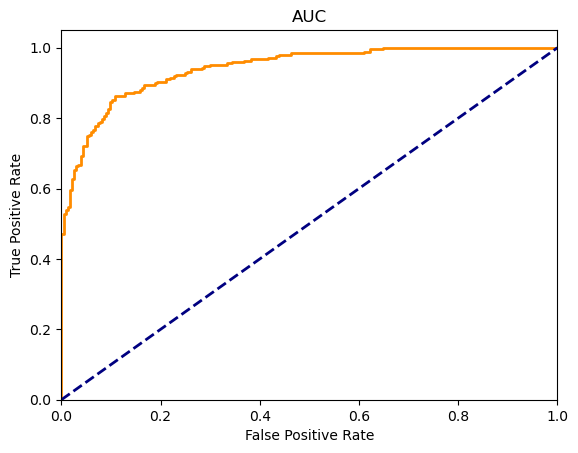

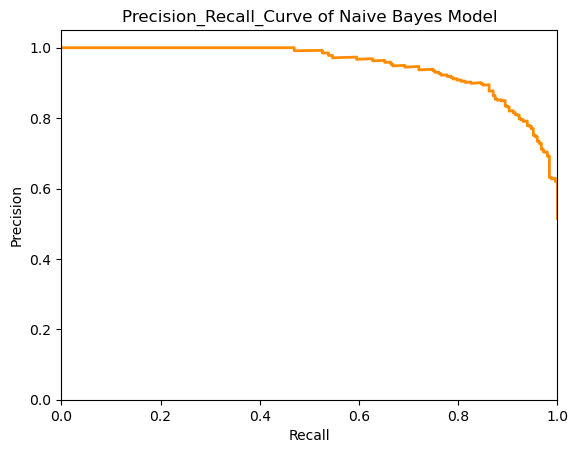

In [26]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           stop_words = 'english', binary = False, 
                           classifier='naive bayes', show_plots = True)



              precision    recall  f1-score   support

       legit       0.87      0.88      0.87       233
        fake       0.88      0.87      0.88       247

    accuracy                           0.88       480
   macro avg       0.87      0.88      0.87       480
weighted avg       0.88      0.88      0.88       480



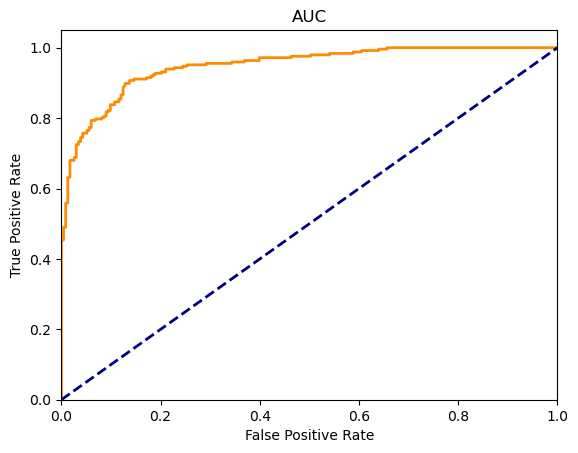

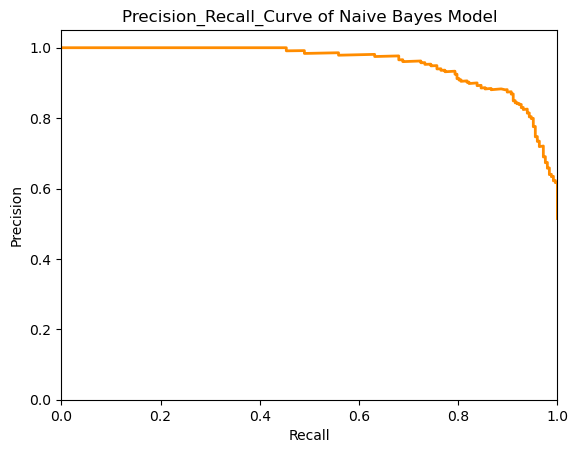

In [27]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           stop_words = 'english', binary = False, 
                           classifier='svm', show_plots = True)

## Q2: Search for best parameters

From Q1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters.

- Define a function `search_para(docs, y, classifier = 'naive bayes')` where `docs` are training documents, `y` is the ground-truth labels, and `classifier` is the model you use.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and the classifier as specified by parameter `classifier` . 
    - Define the parameter ranges as follow: 
        - `stop_words: [None, 'english']`
        - `min_df:[1, 3]`
        - `ngram_range:[(1,1), (1,2), (1,3)]`
        - `binary: [True, False]`
    - Set the scoring metric to `f1_macro`. 
    - Use `GridSearchCV` with `4-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the values of the `best` parameters combination. 
    
- Call this function to find `the best parameters combination` for linear SVM and Naive Bayes models. 
- Call the function `classify` again to use `the best parameters combination`


Please briefly answer the following: 
- Compared with the model in Q1, how is the performance improved on the test dataset?
- Why do you think the new parameter values help deceptive comment classification?

In [38]:
def search_para(docs, y, classifier = 'naive bayes'):
    parameters = {'tfidf__min_df':[1, 3],
                  'tfidf__stop_words':[None,"english"],
                  'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
                  'tfidf__binary':[True, False]}
    
    metric =  "f1_macro"
    
    if classifier == 'naive bayes':
        text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])
    else:
        text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(probability = True))])
        
    gs_clf = GridSearchCV (text_clf, param_grid=parameters, scoring=metric, cv=4)
    gs_clf = gs_clf.fit(docs, y)
    
    for param_name in gs_clf.best_params_:
        print(param_name,":", gs_clf.best_params_[param_name])
    
    

In [39]:
search_para(train["text"], train["label"])

tfidf__binary : True
tfidf__min_df : 3
tfidf__ngram_range : (1, 2)
tfidf__stop_words : None


In [40]:
search_para(train["text"], train["label"], classifier ='svm')

tfidf__binary : True
tfidf__min_df : 3
tfidf__ngram_range : (1, 3)
tfidf__stop_words : None


              precision    recall  f1-score   support

       legit       0.91      0.85      0.88       233
        fake       0.87      0.92      0.89       247

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



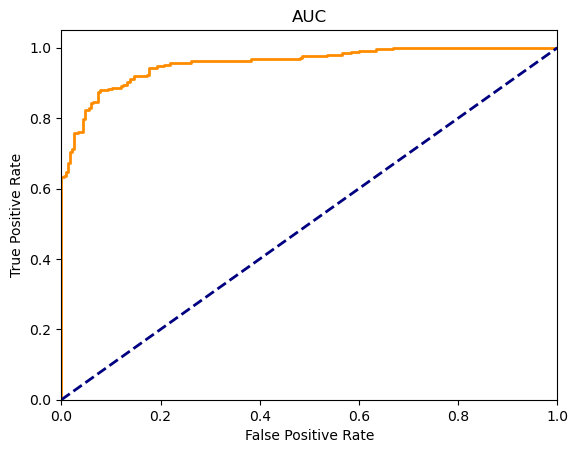

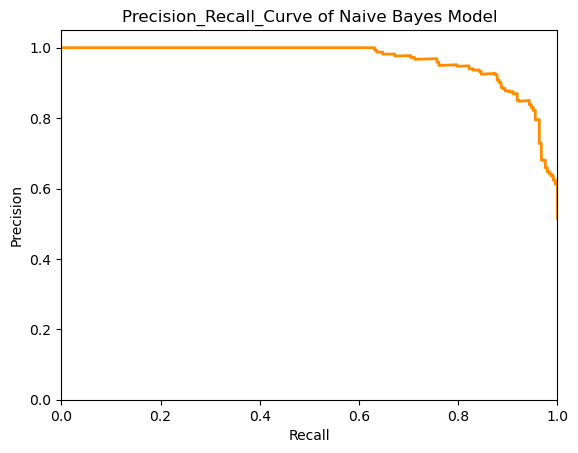

In [41]:
clf, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, min_df = 3, binary=True,
                              ngrams = (1,2), classifier = 'naive bayes', show_plots=True)

              precision    recall  f1-score   support

       legit       0.89      0.88      0.89       233
        fake       0.89      0.90      0.90       247

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



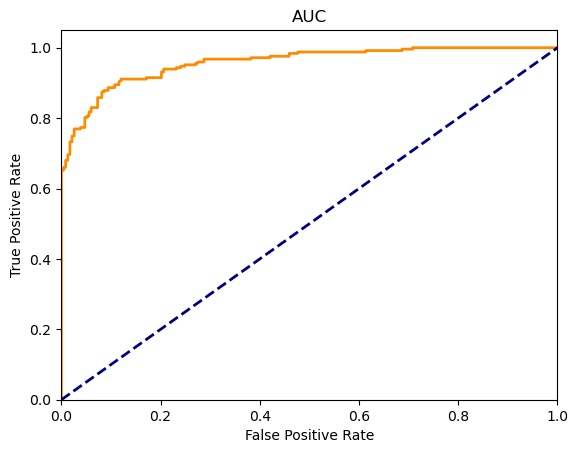

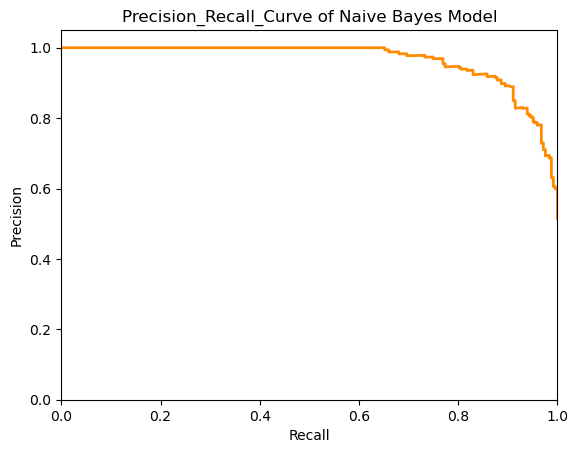

In [42]:
clf, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= 'english', min_df = 2, binary=True,
                              ngrams = (1,3), classifier = 'svm', show_plots=True)

## Q3. Impact of Sample Size 


This task is to help you understand the impact of sample size on classifier performance. 

Define a function `show_sample_size_impact(train_docs, train_y)` where:
- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
    
Conduct the experiment as follows:    
- Starting with 100 samples, in each round you build a classifier with 100 more samples. i.e. in round 1, you use samples from 0 to 100, and in round 2, you use samples from 0 to 200, …, until you use up all samples. 
- In each round, you'll conduct `4-fold cross validation` for both Naive Bayes and Linear SVM algorithms with all `default paramater values` in the TFIDF vectorizer and classifiers. Record the average testing F1-macro score.
- Plot a line chart to show the relationship between sample size and the F1-macro score for SVM and Naive Bayes models. 
- This function has no return.
    
    
- Write your analysis on the following:
    - How does sample size affect each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
  

In [80]:
def show_sample_size_impact(train_docs, train_labels):
    tfidf_vect = TfidfVectorizer(stop_words = 'english', binary = False) 
    tfidf_train_fit_2 = tfidf_vect.fit_transform(train_docs)
    tfidf_train_fit_2 = tfidf_train_fit_2.toarray()
    clf2 = SVC(probability = True)
    clf2.fit(tfidf_train_fit_2, train_docs)
    clf1 = MultinomialNB()
    clf1.fit(tfidf_train_fit_2, train_docs)
    metrics = ["f1_macro", "roc_auc"]
    counter  = len(train_docs) % 100
    counter_2 = len(train_docs)/100
    if counter >= 0:
        if counter == 0:
            i = 1
            r = i*100
        

            #svm
            cv1 = cross_validate(clf1, train_docs[0:r], train_labels[0:r], scoring=metrics, cv=4, return_train_score=True)
            a1 = cv1['test_f1_macro']
            c1 = cv1['test_roc_auc']


            #binomial
            cv2 = cross_validate(clf2, train_docs[0:r], train_labels[0:r], scoring=metrics, cv=4, return_train_score=True)
            a2 = cv2['test_f1_macro']
            c2 = cv2['test_roc_auc']
            results.append((r,np.mean(np.average(a1)),np.mean(np.average(a2)),np.mean(np.average(c1)),np.mean(np.average(c2))))
    
            i+=1
            counter+=1
       
        else:
            cv1 = cross_validate(clf1, train_docs, train_labels, scoring=metrics, cv=4, return_train_score=True)
            a1 = cv1['test_f1_macro']
            c1 = cv1['test_roc_auc']
            cv2 = cross_validate(clf2, train_docs, train_labels, scoring=metrics, cv=4, return_train_score=True)
            a2 = cv2['test_f1_macro']
            c2 = cv2['test_roc_auc']
            results.append((r,np.mean(np.average(a1)),np.mean(np.average(a2)),np.mean(np.average(c1)),np.mean(np.average(c2))))
    
    results=pd.DataFrame(results, columns=["size","f1_svm","f1_nb","auc_svm","auc_nb"])
    results=results.set_index("size") 
    print(colored("F1 SVM vs F1 NB", color="green", attrs=['bold']))
    results[["f1_svm","f1_nb"]].plot(kind="line")

    print(colored("AUC SVM vs AUC NB", color="green", attrs=['bold']))
    results[["auc_svm","auc_nb"]].plot(kind="line")

    
    
    

In [81]:
show_sample_size_impact(train["text"], train["label"])

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 699, in fit
    X, y = self._check_X_y(X, y)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 553, in _check_X_y
    return self._validate_data(X, y, accept_sparse="csr", reset=reset)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/pandas/core/series.py", line 894, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: 'Just back from 5 night stay at Omni and would thoroughly recommend it. Staff bent over backwards to assist in anything, no matter how minute. Great location on magnificent mile and lots to do there both for adults and my 10yo daughter. If i had to find a fault it would be the extra charges, taxes etc for room service, bar and restaurant, but where is cheap these days? Would definitely recommend it, especially for families. \n'

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 699, in fit
    X, y = self._check_X_y(X, y)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 553, in _check_X_y
    return self._validate_data(X, y, accept_sparse="csr", reset=reset)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/Users/subhuatharva/miniconda3/envs/my-env/lib/python3.10/site-packages/pandas/core/series.py", line 894, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: "when i first checked the hotel's website and reviews i was completely sure that it would be a great hotel and i would have a great time there. but i was totally disappointed once i got there, first of all i asked for a nonsmoking room because i hate the odor , and in fact they gave me a non smoking room which smelled worse than a smoking one, it was smelly in a bad way it smelled like sweat and dirty laundry or something like that. then when i was trying to enjoy the view, they windows were all dusty and dirty. so i decided to get out of the room , and i went to the pool and it wasnt what i expected either it has nothing to do with the picture . so i went back to my room and called room service for them to complain about the smell and dirt so they gave me another room which smelled even worse!. i was about to freak out so they gave me some deodorant and it was tolerable; the bed was uncomfortable and the bathroom eww!, its all i can say about this hotel.\n"


## Q4 (Bonus): Model Interpretation 

For this dataset, both Naive Bayes and SVM model can provide good classification accuracy. The question is, how the models conclude that a document is deceptive. What features have the discriminative power? Do your research to find the most descriminative features in a document. To illustrate, you can randomly select a few samples from the test subset to highlight these most discriminative featues.